In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv("/kaggle/input/moviesandtv-csv/Movies_and_TV.csv")

# Show basic info
print(df.head())
print(df.columns)



                        user_id        asin                timestamp
0  AGGZ357AO26RQZVRLGU4D4N52DZQ  B013488XFS  2015-08-24 03:07:17.000
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  B00CB6VTDS  2016-04-19 21:16:50.000
2  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B096Z8Z3R6  2022-03-03 01:43:54.582
3  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B09M14D9FZ  2022-02-27 04:56:01.864
4  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B001H1SVZC  2020-05-28 04:13:47.074
Index(['user_id', 'asin', 'timestamp'], dtype='object')


In [3]:
from sklearn.preprocessing import LabelEncoder

# Encode user_id and asin
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user'] = user_encoder.fit_transform(df['user_id'])
df['item'] = item_encoder.fit_transform(df['asin'])

# Convert timestamp to datetime and sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['user', 'timestamp'])

# Show a sample
print(df.head())
print(f"Total unique users: {df['user'].nunique()}, items: {df['item'].nunique()}")


                              user_id        asin               timestamp  \
2791445  AE2222FRPDMNOMYOMCWIANTXP7UQ  B0091X4AP8 2015-06-11 00:16:50.000   
2791444  AE2222FRPDMNOMYOMCWIANTXP7UQ  B0094K20FK 2015-07-30 19:21:12.000   
2791443  AE2222FRPDMNOMYOMCWIANTXP7UQ  B00BEIYHT2 2016-07-14 20:18:56.000   
2791442  AE2222FRPDMNOMYOMCWIANTXP7UQ  B01CRFKWXK 2016-08-27 13:55:47.000   
2791441  AE2222FRPDMNOMYOMCWIANTXP7UQ  B017S3OP7A 2020-07-29 17:08:21.146   

         user    item  
2791445     0  338085  
2791444     0  339215  
2791443     0  366482  
2791442     0  508873  
2791441     0  492965  
Total unique users: 6503429, items: 747910


In [4]:
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Sample 1000 users
unique_users = df['user'].unique()
sample_users = np.random.choice(unique_users, size=1000, replace=False)

# Filter the dataframe for those users only
df_sample = df[df['user'].isin(sample_users)]

# Group interactions into item sequences
user_interactions = df_sample.groupby('user')['item'].apply(list)

# Check an example
print(user_interactions.head())


user
5134                                              [311921]
12816                                             [411125]
16918                                               [3205]
23162                                     [361440, 228503]
24922    [270031, 317802, 373980, 318389, 233096, 27781...
Name: item, dtype: object


In [5]:
from tqdm import tqdm

sequence_length = 5
X_seq, X_target, y = [], [], []

num_items = df['item'].nunique()  # total items in full dataset

for user, items in tqdm(user_interactions.items()):
    if len(items) <= sequence_length:
        continue
    for i in range(sequence_length, len(items)):
        hist = items[i-sequence_length:i]
        pos_item = items[i]
        # Positive sample
        X_seq.append(hist)
        X_target.append(pos_item)
        y.append(1)
        # Negative sample
        while True:
            neg_item = np.random.randint(num_items)
            if neg_item not in items:
                break
        X_seq.append(hist)
        X_target.append(neg_item)
        y.append(0)

print(f"✅ Done! Total training samples: {len(y)}")


1000it [00:00, 198106.18it/s]

✅ Done! Total training samples: 1588


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class PACADataset(Dataset):
    def __init__(self, sequences, targets, labels):
        self.sequences = sequences
        self.targets = targets
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.long),  # sequence
            torch.tensor(self.targets[idx], dtype=torch.long),    # target item
            torch.tensor(self.labels[idx], dtype=torch.float32)   # label
        )

# Create dataset and dataloader
dataset = PACADataset(X_seq, X_target, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Check one batch
for batch in dataloader:
    seq_batch, target_batch, label_batch = batch
    print("Sequence shape:", seq_batch.shape)
    print("Target shape:", target_batch.shape)
    print("Label shape:", label_batch.shape)
    break



Sequence shape: torch.Size([64, 5])
Target shape: torch.Size([64])
Label shape: torch.Size([64])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class PACA(nn.Module):
    def __init__(self, num_items, embed_dim=64, sequence_length=5):
        super(PACA, self).__init__()
        self.item_embedding = nn.Embedding(num_items, embed_dim)
        self.position_embedding = nn.Embedding(sequence_length, embed_dim)

        self.conv = nn.Conv1d(embed_dim, embed_dim, kernel_size=3, padding=1)

        self.attention = nn.Linear(embed_dim * 2, 1)  # concat(item + pos)
        self.output = nn.Linear(embed_dim, 1)  # final scoring with target

    def forward(self, seq, target):
        # Embedding lookup
        seq_emb = self.item_embedding(seq)  # [B, L, D]
        pos_ids = torch.arange(seq.shape[1], device=seq.device).unsqueeze(0)
        pos_emb = self.position_embedding(pos_ids)  # [1, L, D]

        # Add position embedding
        x = seq_emb + pos_emb  # [B, L, D]
        x = x.permute(0, 2, 1)  # [B, D, L] for conv
        x = self.conv(x)  # [B, D, L]
        x = x.permute(0, 2, 1)  # [B, L, D]

        # Attention over positions
        concat = torch.cat([x, pos_emb.expand_as(x)], dim=-1)  # [B, L, 2D]
        attn_weights = self.attention(concat).squeeze(-1)  # [B, L]
        attn_weights = F.softmax(attn_weights, dim=-1)

        # Weighted sum
        context = torch.sum(attn_weights.unsqueeze(-1) * x, dim=1)  # [B, D]

        # Target embedding
        target_emb = self.item_embedding(target)  # [B, D]

        # Final score (dot product)
        scores = torch.sum(context * target_emb, dim=-1)  # [B]
        return scores


In [8]:
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = PACA(num_items=num_items, embed_dim=64, sequence_length=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

# Training loop
def train(model, dataloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        all_labels, all_preds = [], []

        for seq, target, label in dataloader:
            seq, target, label = seq.to(device), target.to(device), label.to(device)

            optimizer.zero_grad()
            logits = model(seq, target)
            loss = loss_fn(logits, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_labels.extend(label.cpu().numpy())
            all_preds.extend(torch.sigmoid(logits).detach().cpu().numpy())

        auc = roc_auc_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, AUC = {auc:.4f}")

# Train the model
train(model, dataloader, epochs=5)


Epoch 1: Loss = 28.9409, AUC = 0.5159
Epoch 2: Loss = 17.7997, AUC = 0.7088
Epoch 3: Loss = 12.2792, AUC = 0.8449
Epoch 4: Loss = 8.6115, AUC = 0.9392
Epoch 5: Loss = 6.2495, AUC = 0.9803


In [10]:
# Put model in evaluation mode
model.eval()

# Prepare data for predictions (for simplicity, we'll use the same dataset here)
predictions = []
true_labels = []

# Loop through the DataLoader
for batch in dataloader:
    seq_batch, target_batch, label_batch = batch

    # Forward pass to get model scores
    scores = model(seq_batch, target_batch)
    predictions.extend(scores.detach().cpu().numpy())
    true_labels.extend(label_batch.cpu().numpy())

# Convert predictions and true_labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

print(f"Predictions: {predictions[:5]}")  # Display a small sample


Predictions: [-2.28477   -3.0530643 -1.7637105  2.6993153 -4.684033 ]


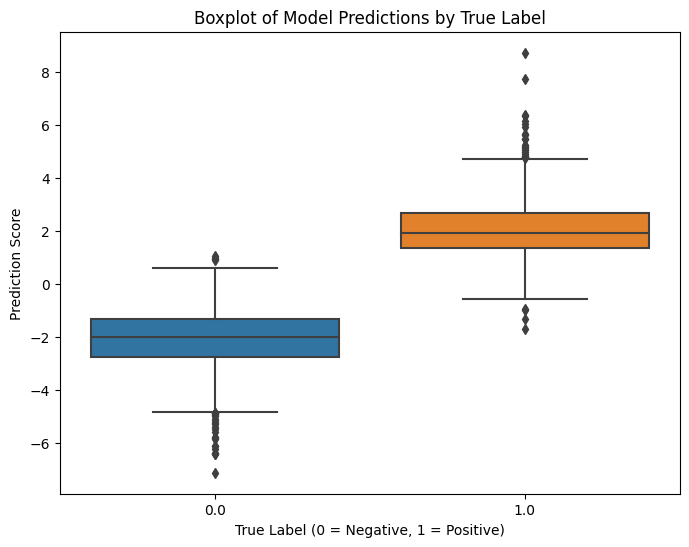

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for easier plotting
df_predictions = pd.DataFrame({'Prediction': predictions, 'True Label': true_labels})

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='True Label', y='Prediction', data=df_predictions)
plt.title('Boxplot of Model Predictions by True Label')
plt.xlabel('True Label (0 = Negative, 1 = Positive)')
plt.ylabel('Prediction Score')
plt.show()


In [12]:
# Save the boxplot as an image
plt.figure(figsize=(8, 6))
sns.boxplot(x='True Label', y='Prediction', data=df_predictions)
plt.title('Boxplot of Model Predictions by True Label')
plt.xlabel('True Label (0 = Negative, 1 = Positive)')
plt.ylabel('Prediction Score')

# Save the plot to the working directory
plt.savefig('/kaggle/working/model_predictions_boxplot.png', bbox_inches='tight')

plt.close()  # Close the plot to free memory


In [13]:
# Convert the predicted scores to binary labels (1 if score > 0, else 0)
predicted_labels = (predictions > 0).astype(int)

# Print a sample to check
print(predicted_labels[:5])  # Display the first 5 predicted labels


[0 0 0 1 0]


In [14]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[778  16]
 [ 17 777]]


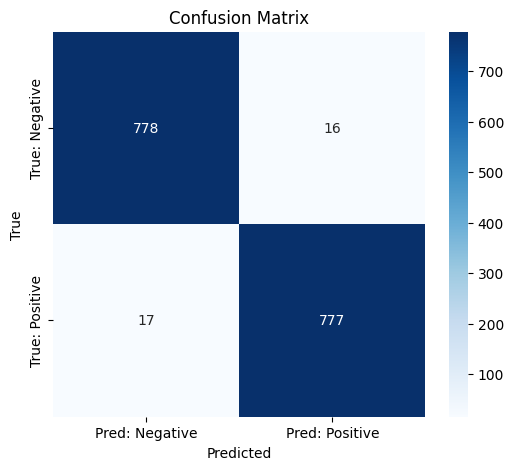

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
    xticklabels=['Pred: Negative', 'Pred: Positive'], 
    yticklabels=['True: Negative', 'True: Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [16]:
# Plot confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: Negative', 'Pred: Positive'], yticklabels=['True: Negative', 'True: Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the plot to the working directory in Kaggle
plt.savefig('/kaggle/working/confusion_matrix.png', bbox_inches='tight')

# Close the plot to free memory
plt.close()


In [18]:
# Assuming the sequence length is always 5
seq_length = 5

for user, items in user_interactions.items():
    # Generate scores for each item for the current user
    if len(items) < seq_length:
        continue  # Skip if there aren't enough items to form a sequence
    
    seq = torch.tensor([items[:seq_length]], dtype=torch.long)
    target = torch.tensor(items[:seq_length], dtype=torch.long)

    # Create position IDs (it should match the sequence length)
    pos_ids = torch.arange(len(seq[0]), device=seq.device).unsqueeze(0)

    # Get predictions from the model
    with torch.no_grad():
        scores = model(seq, target)  # Get the predicted scores for the sequence

    # Store predictions
    user_item_scores[user] = dict(zip(items, scores.detach().numpy()))  # Store predictions for each item


In [19]:
def calculate_precision_recall_at_k(user_item_scores, user_interactions, k=5):
    precision_at_k = []
    recall_at_k = []

    for user, predicted_scores in user_item_scores.items():
        # Get the actual items the user interacted with
        actual_items = set(user_interactions[user])

        # Sort the predicted items by score in descending order and get the top-k items
        top_k_items = sorted(predicted_scores, key=predicted_scores.get, reverse=True)[:k]

        # Calculate precision@k (how many of the top-k predicted items are actually interacted by the user)
        precision = len(set(top_k_items).intersection(actual_items)) / k

        # Calculate recall@k (how many of the user's actual interacted items are in the top-k predicted items)
        recall = len(set(top_k_items).intersection(actual_items)) / len(actual_items)

        precision_at_k.append(precision)
        recall_at_k.append(recall)

    return np.mean(precision_at_k), np.mean(recall_at_k)

# Calculate Precision@k and Recall@k for k=5
precision, recall = calculate_precision_recall_at_k(user_item_scores, user_interactions, k=5)

print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")


Precision@5: 0.9590
Recall@5: 0.6694


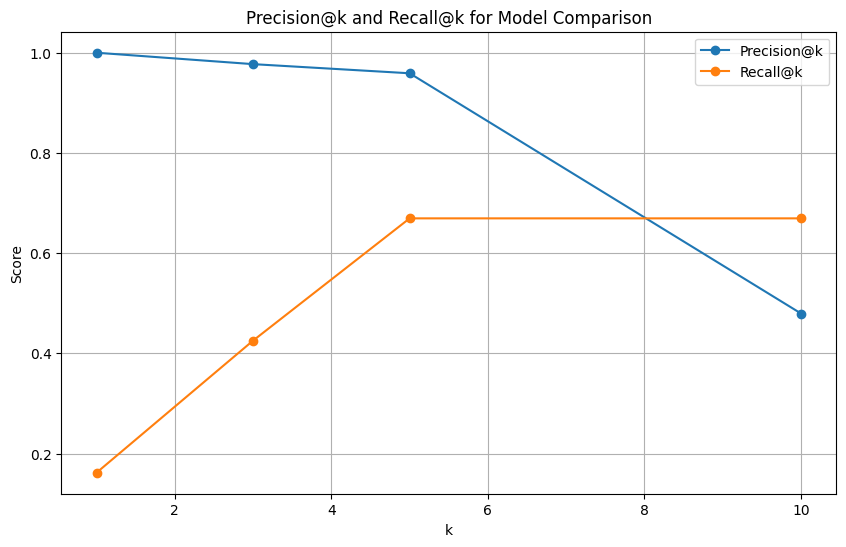

In [20]:
import matplotlib.pyplot as plt

def calculate_precision_recall_at_k_multiple_k(user_item_scores, user_interactions, ks=[1, 3, 5, 10]):
    precision_at_k = {k: [] for k in ks}
    recall_at_k = {k: [] for k in ks}

    for user, predicted_scores in user_item_scores.items():
        # Get the actual items the user interacted with
        actual_items = set(user_interactions[user])

        # Sort the predicted items by score in descending order
        sorted_items = sorted(predicted_scores, key=predicted_scores.get, reverse=True)

        for k in ks:
            top_k_items = sorted_items[:k]

            # Calculate precision@k
            precision = len(set(top_k_items).intersection(actual_items)) / k
            precision_at_k[k].append(precision)

            # Calculate recall@k
            recall = len(set(top_k_items).intersection(actual_items)) / len(actual_items)
            recall_at_k[k].append(recall)

    # Calculate the average Precision@k and Recall@k for each k
    avg_precision_at_k = {k: np.mean(precision_at_k[k]) for k in ks}
    avg_recall_at_k = {k: np.mean(recall_at_k[k]) for k in ks}

    return avg_precision_at_k, avg_recall_at_k

# Calculate Precision@k and Recall@k for k=[1, 3, 5, 10]
ks = [1, 3, 5, 10]
avg_precision, avg_recall = calculate_precision_recall_at_k_multiple_k(user_item_scores, user_interactions, ks)

# Plot Precision@k and Recall@k
plt.figure(figsize=(10, 6))

# Plot Precision@k
plt.plot(list(avg_precision.keys()), list(avg_precision.values()), label='Precision@k', marker='o')

# Plot Recall@k
plt.plot(list(avg_recall.keys()), list(avg_recall.values()), label='Recall@k', marker='o')

# Add labels and title
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Precision@k and Recall@k for Model Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
